## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [38]:
import os
import glob
from google.colab import drive

## connect your drive with the notebook
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
project_folder = "/content/drive/MyDrive/DSBA M2/2 Advanced Deep Learning/Practical Session 1"

In [40]:
# Load data:
df = pd.read_csv(project_folder+"/house_prices.csv")

In [41]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [7]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


In [8]:
df.describe().iloc[1].to_numpy()

array([6.09931507e+00, 1.97126781e+03, 1.05742945e+03, 1.51546370e+03,
       1.80921196e+05])

### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

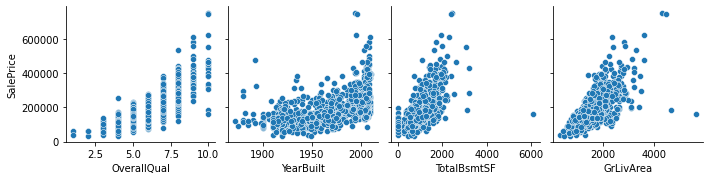

In [9]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [42]:
normalized_df = (df - df.mean()) / df.std()

In [43]:
X = normalized_df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = normalized_df['SalePrice'] # get the target values

In [44]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [45]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(4, 1) # 这里输入是4维的，输出是1维的
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [46]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [47]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [50]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, logs=True, flatten=True):
    train_error = []
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):
            if flatten:
                y_pre = model(X).view(-1)
            else:
                y_pre = model(X)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        train_error.append(epoch_average_loss)
        if logs and ((epoch+1)%1 == 0):
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))
    return train_error

In [51]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set)
0 # 这个0代表原本的return值不再被打印了！

Epoch [1/10], Loss_error: 0.5606
Epoch [2/10], Loss_error: 0.2241
Epoch [3/10], Loss_error: 0.2205
Epoch [4/10], Loss_error: 0.2191
Epoch [5/10], Loss_error: 0.2194
Epoch [6/10], Loss_error: 0.2189
Epoch [7/10], Loss_error: 0.2193
Epoch [8/10], Loss_error: 0.2186
Epoch [9/10], Loss_error: 0.2207
Epoch [10/10], Loss_error: 0.2190


0

#### Evaluate the Model on the validation set

In [52]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad(): # 被with torch.no_grad()包住的代码，不用跟踪反向梯度计算，可以用到val里面，加快速度
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 0.24409982562065125


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

In [53]:
# Construct a model with multiple layers
class ModelMultipleLayers(nn.Module):
    
    def __init__(self, hidden_1=None, hidden_2=None, hidden_3=None, activation=None, output_dim=1):
        super(ModelMultipleLayers, self).__init__()
        
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.hidden_3 = hidden_3
        self.activation = activation

        if self.hidden_1 is not None:
          self.l1 = nn.Linear(4, self.hidden_1)
          if self.hidden_2 is not None:
            self.l2 = nn.Linear(self.hidden_1, self.hidden_2)
            if self.hidden_3 is not None:
              self.l3 = nn.Linear(self.hidden_2, self.hidden_3)
              self.l4 = nn.Linear(self.hidden_3, output_dim)
            else:
              self.l3 = nn.Linear(self.hidden_2, output_dim)
          else:
            self.l2 = nn.Linear(hidden_1, output_dim)
        else:
          self.l1 = nn.Linear(4, output_dim)
        
    def forward(self, inputs):
        if self.hidden_1 is None:
          outputs = self.l1(inputs)
        elif self.hidden_2 is None:
          outputs = self.l2(F.relu(self.l1(inputs)))
        elif self.hidden_3 is None:
          outputs = self.l3(F.relu(self.l2(F.relu(self.l1(inputs)))))
        else:
          outputs = self.l4(F.relu(self.l3(F.relu(self.l2(F.relu(self.l1(inputs)))))))
        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

#### a) Impact of the number of layers
##### One Hidden Layer

Epoch [1/20], Loss_error: 0.2917
Epoch [2/20], Loss_error: 0.1971
Epoch [3/20], Loss_error: 0.1955
Epoch [4/20], Loss_error: 0.2014
Epoch [5/20], Loss_error: 0.1989
Epoch [6/20], Loss_error: 0.1976
Epoch [7/20], Loss_error: 0.1928
Epoch [8/20], Loss_error: 0.1854
Epoch [9/20], Loss_error: 0.1848
Epoch [10/20], Loss_error: 0.1833
Epoch [11/20], Loss_error: 0.1847
Epoch [12/20], Loss_error: 0.1847
Epoch [13/20], Loss_error: 0.1770
Epoch [14/20], Loss_error: 0.1778
Epoch [15/20], Loss_error: 0.1918
Epoch [16/20], Loss_error: 0.1882
Epoch [17/20], Loss_error: 0.1772
Epoch [18/20], Loss_error: 0.1778
Epoch [19/20], Loss_error: 0.1820
Epoch [20/20], Loss_error: 0.1696


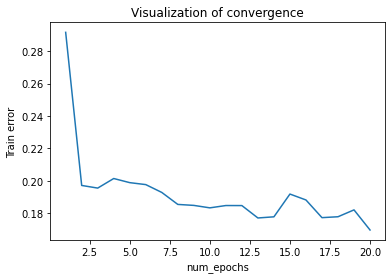

The loss on validation set is: 0.15626418590545654


In [42]:
model = ModelMultipleLayers(100)

num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

##### Two hidden layers

Epoch [1/20], Loss_error: 0.3422
Epoch [2/20], Loss_error: 0.1987
Epoch [3/20], Loss_error: 0.1887
Epoch [4/20], Loss_error: 0.1933
Epoch [5/20], Loss_error: 0.1913
Epoch [6/20], Loss_error: 0.1886
Epoch [7/20], Loss_error: 0.1876
Epoch [8/20], Loss_error: 0.1875
Epoch [9/20], Loss_error: 0.1778
Epoch [10/20], Loss_error: 0.1800
Epoch [11/20], Loss_error: 0.1893
Epoch [12/20], Loss_error: 0.1805
Epoch [13/20], Loss_error: 0.1747
Epoch [14/20], Loss_error: 0.1813
Epoch [15/20], Loss_error: 0.1698
Epoch [16/20], Loss_error: 0.1695
Epoch [17/20], Loss_error: 0.1726
Epoch [18/20], Loss_error: 0.1721
Epoch [19/20], Loss_error: 0.1740
Epoch [20/20], Loss_error: 0.1734


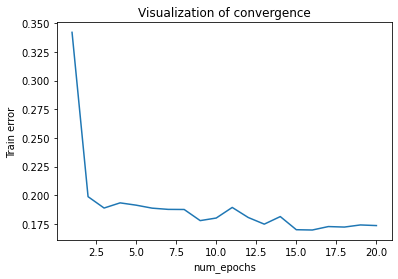

The loss on validation set is: 0.16233207285404205


In [43]:
model = ModelMultipleLayers(100, 100)

num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

###### Three hidden layers

Epoch [1/20], Loss_error: 0.4934
Epoch [2/20], Loss_error: 0.2233
Epoch [3/20], Loss_error: 0.2026
Epoch [4/20], Loss_error: 0.2028
Epoch [5/20], Loss_error: 0.1825
Epoch [6/20], Loss_error: 0.1936
Epoch [7/20], Loss_error: 0.1914
Epoch [8/20], Loss_error: 0.1904
Epoch [9/20], Loss_error: 0.1849
Epoch [10/20], Loss_error: 0.1858
Epoch [11/20], Loss_error: 0.1855
Epoch [12/20], Loss_error: 0.1628
Epoch [13/20], Loss_error: 0.1853
Epoch [14/20], Loss_error: 0.1722
Epoch [15/20], Loss_error: 0.1749
Epoch [16/20], Loss_error: 0.1689
Epoch [17/20], Loss_error: 0.1590
Epoch [18/20], Loss_error: 0.1906
Epoch [19/20], Loss_error: 0.1805
Epoch [20/20], Loss_error: 0.1685


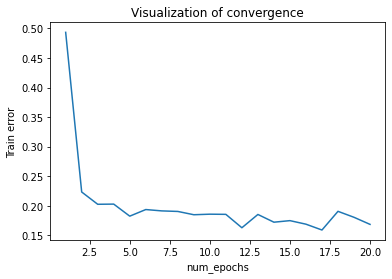

The loss on validation set is: 0.3587101995944977


In [44]:
model = ModelMultipleLayers(100, 100, 100)

num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

#### b) Impact of the activation function

Validation loss with activation 'None': 0.15788736939430237
Validation loss with activation 'Sigmoid': 0.7700819373130798
Validation loss with activation 'Tanh': 0.5111200213432312
Validation loss with activation 'ReLU': 0.45188963413238525


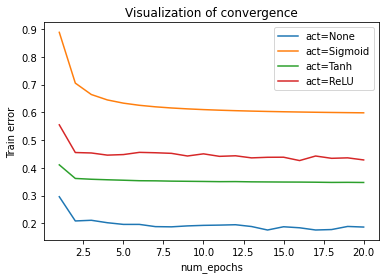

In [54]:
num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

activation_names = ["None", "Sigmoid", "Tanh", "ReLU"]
for i, activation in enumerate([None, torch.sigmoid, torch.tanh, F.relu]):
    model = ModelMultipleLayers(100, activation=activation)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="act={}".format(activation_names[i]))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with activation '{}': {}".format(activation_names[i], error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

#### c) Impact of the number of neurons per layer

1 hidden layer:
Validation loss with 5 neurons per layer: 0.18187496066093445
Validation loss with 10 neurons per layer: 0.18619589507579803
Validation loss with 20 neurons per layer: 0.1703452318906784
Validation loss with 50 neurons per layer: 0.1660165786743164
Validation loss with 100 neurons per layer: 0.16202230751514435


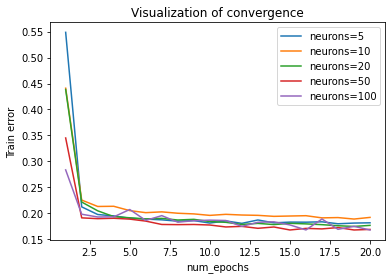


2 hidden layers:
Validation loss with 5 neurons per layer: 0.21162739396095276
Validation loss with 10 neurons per layer: 0.17527976632118225
Validation loss with 20 neurons per layer: 0.17207077145576477
Validation loss with 50 neurons per layer: 0.17588397860527039
Validation loss with 100 neurons per layer: 0.20419402420520782


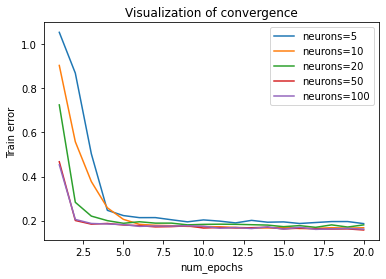


3 hidden layers:
Validation loss with 5 neurons per layer: 0.19744153320789337
Validation loss with 10 neurons per layer: 0.21679633855819702
Validation loss with 20 neurons per layer: 0.1953873187303543
Validation loss with 50 neurons per layer: 0.17189940810203552
Validation loss with 100 neurons per layer: 0.1567116528749466


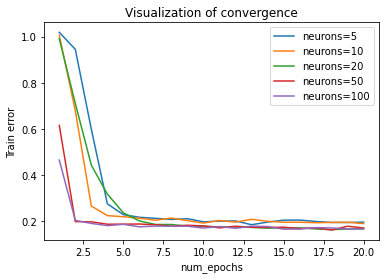

In [46]:
num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

print("1 hidden layer:")

for neurons in [5, 10, 20, 50, 100]:
    model = ModelMultipleLayers(neurons)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="neurons={}".format(neurons))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with {} neurons per layer: {}".format(neurons, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

print("\n2 hidden layers:")

for neurons in [5, 10, 20, 50, 100]:
    model = ModelMultipleLayers(neurons, neurons)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="neurons={}".format(neurons))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with {} neurons per layer: {}".format(neurons, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

print("\n3 hidden layers:")

for neurons in [5, 10, 20, 50, 100]:
    model = ModelMultipleLayers(neurons, neurons, neurons)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="neurons={}".format(neurons))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with {} neurons per layer: {}".format(neurons, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()


### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

#### a) Impact of the batch size

Validation loss with a batch size of 10: 0.1690874695777893
Validation loss with a batch size of 20: 0.17382371425628662
Validation loss with a batch size of 50: 0.2045179009437561
Validation loss with a batch size of 100: 0.2014106959104538
Validation loss with a batch size of 200: 0.22265419363975525
Validation loss with a batch size of 400: 0.2091909795999527


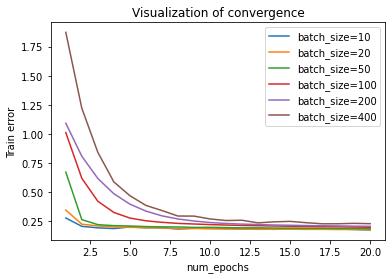

In [47]:
num_epochs = 20

criterion = nn.MSELoss()

for batch_size in [10, 20, 50, 100, 200, 400]:
    model = ModelMultipleLayers(50)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="batch_size={}".format(batch_size))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with a batch size of {}: {}".format(batch_size, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

#### b) Impact of the learning rate

Validation loss with a learning rate of 0.001: 0.206086203455925
Validation loss with a learning rate of 0.005: 0.17464111745357513
Validation loss with a learning rate of 0.01: 0.24491016566753387
Validation loss with a learning rate of 0.05: 0.1870705634355545
Validation loss with a learning rate of 0.1: 0.43745002150535583
Validation loss with a learning rate of 0.5: nan
Validation loss with a learning rate of 1: nan
Validation loss with a learning rate of 5: nan
Validation loss with a learning rate of 10: nan


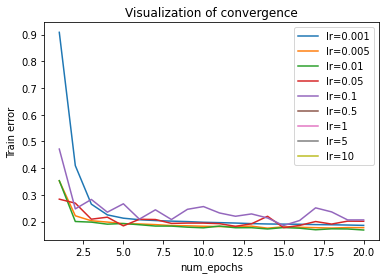

In [48]:
num_epochs = 20
batch_size = 10

criterion = nn.MSELoss()

for lr in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
    model = ModelMultipleLayers(50)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="lr={}".format(lr))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with a learning rate of {}: {}".format(lr, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

#### c) Impact of the number of epochs

Validation loss after 10 epochs: 0.17670686542987823
Validation loss after 20 epochs: 0.19980807602405548
Validation loss after 50 epochs: 0.20462436974048615
Validation loss after 100 epochs: 0.16858547925949097
Validation loss after 200 epochs: 0.15968430042266846


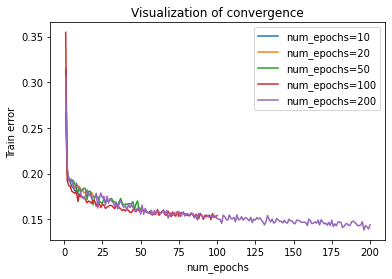

In [49]:
batch_size = 10

criterion = nn.MSELoss()

for num_epochs in [10, 20, 50, 100, 200]:
    model = ModelMultipleLayers(50)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="num_epochs={}".format(num_epochs))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss after {} epochs: {}".format(num_epochs, error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

#### d) Impact of the optimizer

Validation loss with the 'SGD' optimizer: 0.20926161110401154
Validation loss with the 'ADAM' optimizer: 0.16140161454677582
Validation loss with the 'RMSprop' optimizer: 0.18757487833499908


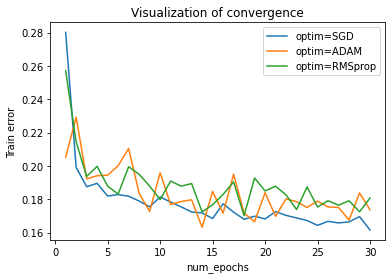

In [50]:
num_epochs = 30
batch_size = 10

criterion = nn.MSELoss()

optimizer_names = ["SGD", "ADAM", "RMSprop"]
for i, optimizer_function in enumerate([torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]):
    model = ModelMultipleLayers(50)
    optimizer = optimizer_function(model.parameters(), lr=0.01)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, logs=False)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label="optim={}".format(optimizer_names[i]))

    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print("Validation loss with the '{}' optimizer: {}".format(optimizer_names[i], error))

plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.legend()
plt.show()

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


In [33]:
def gaussian_likelihood(input, target):
    mu, log_sigma_square = input[:, 0], input[:, 1]
    second_term = torch.square(target - mu) / torch.exp(log_sigma_square)
    torch.pi = torch.acos(torch.zeros(1)).item()
    return torch.mean(log_sigma_square + second_term + 0.5*torch.log(torch.tensor(2*torch.pi)))

Epoch [1/30], Loss_error: 0.9545
Epoch [2/30], Loss_error: 0.2623
Epoch [3/30], Loss_error: 0.1652
Epoch [4/30], Loss_error: 0.1340
Epoch [5/30], Loss_error: 0.1132
Epoch [6/30], Loss_error: 0.0992
Epoch [7/30], Loss_error: 0.1010
Epoch [8/30], Loss_error: 0.0887
Epoch [9/30], Loss_error: 0.0910
Epoch [10/30], Loss_error: 0.0834
Epoch [11/30], Loss_error: 0.0841
Epoch [12/30], Loss_error: 0.0831
Epoch [13/30], Loss_error: 0.0825
Epoch [14/30], Loss_error: 0.0815
Epoch [15/30], Loss_error: 0.0790
Epoch [16/30], Loss_error: 0.0770
Epoch [17/30], Loss_error: 0.0772
Epoch [18/30], Loss_error: 0.0773
Epoch [19/30], Loss_error: 0.0707
Epoch [20/30], Loss_error: 0.0710
Epoch [21/30], Loss_error: 0.0734
Epoch [22/30], Loss_error: 0.0721
Epoch [23/30], Loss_error: 0.0707
Epoch [24/30], Loss_error: 0.0700
Epoch [25/30], Loss_error: 0.0699
Epoch [26/30], Loss_error: 0.0701
Epoch [27/30], Loss_error: 0.0694
Epoch [28/30], Loss_error: 0.0659
Epoch [29/30], Loss_error: 0.0632
Epoch [30/30], Loss_err

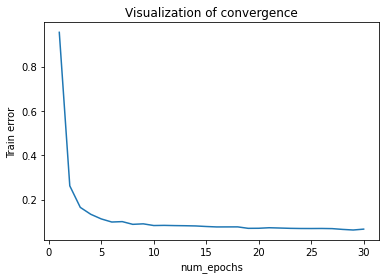

The loss on validation set is: 0.09971574693918228


In [55]:
model = ModelMultipleLayers(100, 100, 100, activation=torch.tanh, output_dim=2)

num_epochs = 30
batch_size = 10

criterion = gaussian_likelihood # 还可以直接定义个方程然后直接等于名字的。。

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, flatten=False)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

#### a) Test set evaluation

Epoch [1/30], Loss_error: 0.8577
Epoch [2/30], Loss_error: 0.5838
Epoch [3/30], Loss_error: 0.3372
Epoch [4/30], Loss_error: 0.2346
Epoch [5/30], Loss_error: 0.2104
Epoch [6/30], Loss_error: 0.2013
Epoch [7/30], Loss_error: 0.1974
Epoch [8/30], Loss_error: 0.1914
Epoch [9/30], Loss_error: 0.1887
Epoch [10/30], Loss_error: 0.1874
Epoch [11/30], Loss_error: 0.1818
Epoch [12/30], Loss_error: 0.1816
Epoch [13/30], Loss_error: 0.1782
Epoch [14/30], Loss_error: 0.1819
Epoch [15/30], Loss_error: 0.1788
Epoch [16/30], Loss_error: 0.1760
Epoch [17/30], Loss_error: 0.1790
Epoch [18/30], Loss_error: 0.1765
Epoch [19/30], Loss_error: 0.1747
Epoch [20/30], Loss_error: 0.1747
Epoch [21/30], Loss_error: 0.1731
Epoch [22/30], Loss_error: 0.1717
Epoch [23/30], Loss_error: 0.1695
Epoch [24/30], Loss_error: 0.1742
Epoch [25/30], Loss_error: 0.1710
Epoch [26/30], Loss_error: 0.1701
Epoch [27/30], Loss_error: 0.1698
Epoch [28/30], Loss_error: 0.1691
Epoch [29/30], Loss_error: 0.1709
Epoch [30/30], Loss_err

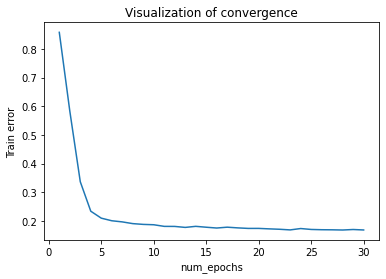

The loss on validation set is: 0.17314964532852173
The loss on test set is: 0.38580724596977234


In [70]:
# Training with the MSE loss

model = ModelMultipleLayers(100, 100, 100)

num_epochs = 30
batch_size = 50

criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float()).view(-1)
error = criterion(y_pre_test, torch.tensor(np.array(y_test)).float()).item()
print('The loss on test set is:', error)

#### b) Uncertainty for the Gaussian Likelihood loss

Epoch [1/30], Loss_error: 0.9742
Epoch [2/30], Loss_error: 0.2569
Epoch [3/30], Loss_error: 0.1579
Epoch [4/30], Loss_error: 0.1297
Epoch [5/30], Loss_error: 0.1132
Epoch [6/30], Loss_error: 0.1083
Epoch [7/30], Loss_error: 0.1001
Epoch [8/30], Loss_error: 0.0975
Epoch [9/30], Loss_error: 0.0898
Epoch [10/30], Loss_error: 0.0838
Epoch [11/30], Loss_error: 0.0862
Epoch [12/30], Loss_error: 0.0834
Epoch [13/30], Loss_error: 0.0840
Epoch [14/30], Loss_error: 0.0851
Epoch [15/30], Loss_error: 0.0825
Epoch [16/30], Loss_error: 0.0780
Epoch [17/30], Loss_error: 0.0730
Epoch [18/30], Loss_error: 0.0773
Epoch [19/30], Loss_error: 0.0762
Epoch [20/30], Loss_error: 0.0752
Epoch [21/30], Loss_error: 0.0756
Epoch [22/30], Loss_error: 0.0707
Epoch [23/30], Loss_error: 0.0766
Epoch [24/30], Loss_error: 0.0705
Epoch [25/30], Loss_error: 0.0694
Epoch [26/30], Loss_error: 0.0700
Epoch [27/30], Loss_error: 0.0750
Epoch [28/30], Loss_error: 0.0686
Epoch [29/30], Loss_error: 0.0707
Epoch [30/30], Loss_err

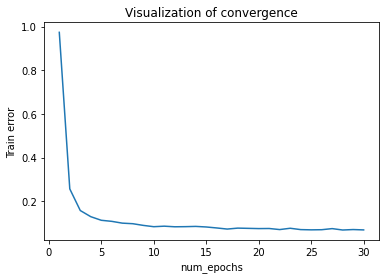

The loss on validation set is: 0.10282602906227112
The loss on test set is: 0.012819519266486168


In [35]:
# Training with the Gaussian Likelihood Loss

model = ModelMultipleLayers(100, 100, 100, activation=torch.tanh, output_dim=2)

num_epochs = 30
batch_size = 10

criterion = gaussian_likelihood

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, flatten=False)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float())
error = criterion(y_pre_test, torch.tensor(np.array(y_test)).float()).item()
print('The loss on test set is:', error)

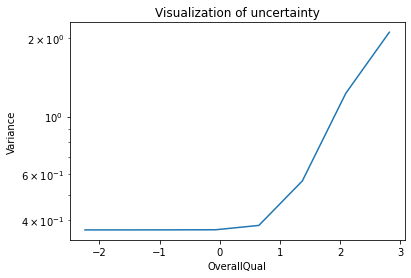

In [36]:
feature = X_test["OverallQual"].to_numpy()
variance = np.exp(y_pre_test[:, 1].numpy())

# Average the variance for equal values of the feature
x = []
y = []
count = []
for i in range(len(feature)):
  if feature[i] in x:
    y[x.index(feature[i])] += variance[i]
    count[x.index(feature[i])] += 1
  else:
    x.append(feature[i])
    y.append(variance[i])
    count.append(1)
x, y, count = np.array(x), np.array(y), np.array(count)
y = y / count
order = np.argsort(x)

plt.plot(x[order], y[order])
plt.xlabel("OverallQual")
plt.ylabel("Variance")
plt.title("Visualization of uncertainty")
plt.yscale("log")
plt.show()